<a href="https://colab.research.google.com/github/remcova/Audio-Effects/blob/master/Transformer_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements

In [1]:
%load_ext google.colab.data_table
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.0


In [2]:
!pip install finta

In [3]:
import plotly.graph_objects as go
from google.colab import drive
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, Activation
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from pathlib import Path
from finta import TA
import shutil

# Connect with Google Drive

In [4]:
drive.mount('/content/gdrive', force_remount=True)
orders_dir_path = '/content/gdrive/My Drive/FX/Algos/Dataset_Old/15min'
print(orders_dir_path)

Mounted at /content/gdrive
/content/gdrive/My Drive/FX/Algos/Dataset_Old/15min


# Collect data

In [5]:
# Create main data frame for dataset
dataset_dataframe = pd.DataFrame()
total_candles = 31

# Create Label Encoders
le_result = LabelEncoder()
le_result.fit(["Win", "Loss"])

def preprocess_data(file_path):
  # Making data frame for the current CSV file
  data = pd.read_csv(file_path)
  df = pd.DataFrame(data)

  # Normalizing data
  df['Result'] = le_result.fit_transform(df['Result'])

  # Creating columns
  df['Month of year'] = None
  df['Day of month'] = None
  df['Day of week'] = None
  df['Hour of day'] = None
  df['Minute of hour'] = None

  # Set values for created rows
  for index, row in df.iterrows():
    date = datetime.datetime.strptime(row['Open time'], "%Y-%m-%d %H:%M:%S")
    df.loc[index,'Open time'] = date
    df.loc[index,'Month of year'] = date.month
    df.loc[index,'Day of month'] = date.day
    df.loc[index,'Day of week'] = date.weekday()
    df.loc[index,'Hour of day'] = date.hour
    df.loc[index,'Minute of hour'] = date.minute
    
  return df  


# Iterate through all Order Data in Google Drive
pathlist = Path(orders_dir_path).rglob('*.csv')
count = 0
for path in pathlist:
  # if count == 0:
  orders_file_path = str(path)

  # Append Dataframe to the Dataset Dataframe
  main_dataframe = preprocess_data(orders_file_path)
  dataset_dataframe = dataset_dataframe.append(main_dataframe)
  # count += 1

dataset_dataframe.index = range(1,len(dataset_dataframe)+1)
dataset_dataframe["Result"] = dataset_dataframe["Result"].astype(int)

# Drop useless columns
dataset_dataframe = dataset_dataframe.drop(columns=["Open price","Open time","Symbol","Buy/sell","Close price","Close time","ATR","Take profit","Stop loss","Close half","Close half time","Profit","Unnamed: 0"])

print(len(dataset_dataframe))

won = 0
lossed = 0

for index, row in dataset_dataframe.iterrows():
  if row['Result'] == 1:
    won+=1
  else:
    lossed+=1

print(won)
print(lossed)

8595
5549
3046


# Add Indicators to the data

In [6]:
# Add Indicators
adx = []
roc = []
zlema = []
sma = []
ssma = []
kama = []
mobo = []
atr = []
rsi = []
macd = []
macd_signal = []
bull = []
bear = []
hma = []
vortex = []


for index, row in dataset_dataframe.iterrows():
    
  data_ohlcv = []

  for i in range(1, total_candles):
    data_ohlcv.append([row['Candle' + str(i) + '_Open'], row['Candle' + str(i) + '_High'], row['Candle' + str(i) + '_Low'], row['Candle' + str(i) + '_Close']])

  dataset_ohlcv = pd.DataFrame(data_ohlcv, columns=["open", "high", "low", "close"])
  dataset_ohlcv.index += 1

  indicator_candles = total_candles-1
  adx.append(TA.ADX(dataset_ohlcv)[indicator_candles])
  roc.append(TA.ROC(dataset_ohlcv)[indicator_candles])
  zlema.append(TA.ZLEMA(dataset_ohlcv, adjust=False)[indicator_candles])
  sma.append(TA.SMA(dataset_ohlcv, period=30)[indicator_candles])
  ssma.append(TA.SSMA(dataset_ohlcv)[indicator_candles])
  kama.append(TA.KAMA(dataset_ohlcv)[indicator_candles])
  if dataset_ohlcv.loc[indicator_candles, 'high'] > TA.MOBO(dataset_ohlcv)['BB_UPPER'][indicator_candles]:
    mobo.append(1)
  else:
    mobo.append(0)
  atr.append(TA.ATR(dataset_ohlcv)[indicator_candles])
  rsi.append(TA.RSI(dataset_ohlcv)[indicator_candles])
  MACD = TA.MACD(dataset_ohlcv)
  macd.append(MACD['MACD'][indicator_candles])
  macd_signal.append(MACD['SIGNAL'][indicator_candles])
  bull.append(TA.EBBP(dataset_ohlcv)['Bull.'][indicator_candles])
  bear.append(TA.EBBP(dataset_ohlcv)['Bear.'][indicator_candles])
  hma.append(TA.HMA(dataset_ohlcv)[indicator_candles])
  VI = TA.VORTEX(dataset_ohlcv)
  VIM = VI['VIm'][indicator_candles]
  VIP = VI['VIp'][indicator_candles]
  if VIP > VIM:
    vortex.append(1)
  else:
    vortex.append(0)

dataset_dataframe['ADX'] = adx
dataset_dataframe['ROC'] = roc
dataset_dataframe['ZLEMA'] = zlema
dataset_dataframe['SMA'] = sma
dataset_dataframe['SSMA'] = ssma
dataset_dataframe['KAMA'] = kama
dataset_dataframe['MOBO'] = mobo
dataset_dataframe['ATR'] = atr
dataset_dataframe['RSI'] = rsi
dataset_dataframe['MACD'] = macd
dataset_dataframe['MACD_SIGNAL'] = macd_signal
dataset_dataframe['BULL'] = bull
dataset_dataframe['BEAR'] = bear
dataset_dataframe['HMA'] = hma
dataset_dataframe['VORTEX'] = vortex

# Delete volume columns

In [7]:
# Delete volume columns
labels_volume = []

for i in range(1, total_candles+1):
  labels_volume.append('Candle' + str(i) + '_Volume')
  
dataset_dataframe = dataset_dataframe.drop(columns=labels_volume)

# Min Max Scaler

In [8]:
scaler = MinMaxScaler()

columns = []

i = 1
while i <= total_candles:
    columns.append('Candle' + str(i) + '_Open')
    columns.append('Candle' + str(i) + '_High')
    columns.append('Candle' + str(i) + '_Low')
    columns.append('Candle' + str(i) + '_Close')
    i+=1

candles = dataset_dataframe[columns].to_numpy()

# Add Price related Indicators
columns.extend(['Resistance', 'ROC', 'ZLEMA', 'SMA', 'SSMA', 'KAMA', 'ATR', 'MACD', 'MACD_SIGNAL', 'BULL', 'BEAR', 'HMA'])

total = dataset_dataframe[columns]
dataset_dataframe = dataset_dataframe.drop(columns, axis=1)
columns_scaled = []

for index, row in enumerate(total.to_numpy()):
  candles_row = candles[index].reshape(-1,1)
  scaler = scaler.fit(candles_row)
  row = row.reshape(-1,1)
  row = scaler.transform(row)
  row = row.reshape(1,-1)
  row = row.tolist()
  columns_scaled.append(row[0])

columns_scaled = pd.DataFrame(columns_scaled, columns=columns)
columns_scaled.index = range(1,len(columns_scaled)+1)

dataset_dataframe = dataset_dataframe.join(columns_scaled)

In [9]:
dataset_dataframe

,Result,Month of year,Day of month,Day of week,Hour of day,Minute of hour,ADX,MOBO,RSI,VORTEX,Candle1_Open,Candle1_High,Candle1_Low,Candle1_Close,Candle2_Open,Candle2_High,Candle2_Low,Candle2_Close,Candle3_Open,Candle3_High,Candle3_Low,Candle3_Close,Candle4_Open,Candle4_High,Candle4_Low,Candle4_Close,Candle5_Open,Candle5_High,Candle5_Low,Candle5_Close,Candle6_Open,Candle6_High,Candle6_Low,Candle6_Close,Candle7_Open,Candle7_High,Candle7_Low,Candle7_Close,Candle8_Open,Candle8_High,...,Candle25_Open,Candle25_High,Candle25_Low,Candle25_Close,Candle26_Open,Candle26_High,Candle26_Low,Candle26_Close,Candle27_Open,Candle27_High,Candle27_Low,Candle27_Close,Candle28_Open,Candle28_High,Candle28_Low,Candle28_Close,Candle29_Open,Candle29_High,Candle29_Low,Candle29_Close,Candle30_Open,Candle30_High,Candle30_Low,Candle30_Close,Candle31_Open,Candle31_High,Candle31_Low,Candle31_Close,Resistance,ROC,ZLEMA,SMA,SSMA,KAMA,ATR,MACD,MACD_SIGNAL,BULL,BEAR,HMA
1,1,1,14,0,2,17,27.800616,1,63.716804,1,0.063910,0.116541,0.000000,0.031955,0.035714,0.146617,0.035714,0.140977,0.140977,0.338346,0.099624,0.293233,0.293233,0.462406,0.221805,0.242481,0.242481,0.242481,0.242481,0.242481,0.451128,0.466165,0.404135,0.454887,0.453008,0.453008,0.421053,0.436090,0.432331,0.453008,...,0.597744,0.812030,0.582707,0.740602,0.742481,0.755639,0.622180,0.676692,0.676692,0.800752,0.652256,0.778195,0.770677,0.770677,0.644737,0.648496,0.652256,0.676692,0.610902,0.642857,0.642857,0.759398,0.635338,0.759398,0.763158,1.0,0.763158,0.990602,0.812030,-227.559089,0.826900,0.497932,0.613394,0.503929,-246.567938,-246.651468,-246.662416,-246.585714,-246.709774,0.730317
2,0,1,17,3,0,53,39.017360,1,61.755271,1,0.705882,0.808824,0.198529,0.375000,0.363971,0.477941,0.246324,0.275735,0.272059,0.433824,0.165441,0.375000,0.360294,0.389706,0.102941,0.338235,0.330882,0.525735,0.250000,0.470588,0.477941,0.507353,0.301471,0.459559,0.455882,0.812500,0.375000,0.812500,0.816176,0.823529,...,0.610294,0.676471,0.573529,0.639706,0.643382,0.676471,0.463235,0.566176,0.566176,0.676471,0.404412,0.404412,0.404412,0.466912,0.283088,0.330882,0.330882,0.382353,0.242647,0.301471,0.301471,0.830882,0.301471,0.816176,0.812500,1.0,0.698529,1.000000,0.691176,-445.404602,0.394244,0.431373,0.477686,0.486959,-481.084296,-481.291435,-481.303774,-480.982621,-481.512033,0.508118
3,1,1,17,3,8,30,28.785951,1,60.650271,1,0.541436,0.662983,0.480663,0.657459,0.654696,0.654696,0.453039,0.486188,0.483425,0.569061,0.430939,0.464088,0.464088,0.552486,0.453039,0.524862,0.530387,0.530387,0.248619,0.298343,0.301105,0.480663,0.270718,0.477901,0.475138,0.569061,0.469613,0.546961,0.544199,0.563536,...,0.693370,0.806630,0.585635,0.635359,0.624309,0.776243,0.502762,0.756906,0.767956,0.767956,0.303867,0.381215,0.383978,0.441989,0.116022,0.436464,0.436464,0.897790,0.378453,0.635359,0.640884,0.906077,0.616022,0.828729,0.823204,1.0,0.823204,0.977901,0.662983,-321.870818,0.499985,0.432873,0.517344,0.522796,-361.631610,-361.832396,-361.862296,-361.538565,-361.828620,0.660908
4,1,1,18,4,3,6,35.885750,1,61.428946,1,0.024793,0.355372,0.024793,0.194215,0.185950,0.504132,0.012397,0.466942,0.462810,0.561983,0.103306,0.239669,0.247934,0.289256,0.000000,0.289256,0.280992,0.309917,0.165289,0.289256,0.289256,0.342975,0.132231,0.206612,0.190083,0.454545,0.181818,0.297521,0.297521,0.471074,...,0.090909,0.338843,0.090909,0.326446,0.338843,0.553719,0.330579,0.396694,0.388430,0.636364,0.206612,0.545455,0.553719,0.768595,0.421488,0.702479,0.702479,0.743802,0.570248,0.685950,0.665289,0.805785,0.611570,0.719008,0.727273,1.0,0.710744,0.958678,0.644628,-520.976358,0.618559,0.385262,0.465683,0.416772,-544.179162,-544.417017,-544.456313,-544.164141,-544.358356,0.580740
5,0,1,21,0,7,27,37.134977,1,58.710760,1,0.572770,0.727700,0.516432,0.718310,0.718310,0.755869,0.361502,0.370892,0.370892,0.417840,0.117371,0.154930,0.154930,0.361502,0.098592,0.305164,0.305164,0.441315,0.136150,0.380282,0.380282,0.699531,0.333333,0.661972,0.657277,0.924883,0.586854,0.671362,0.661972,0.

In [10]:
dataset_dataframe

,Result,Month of year,Day of month,Day of week,Hour of day,Minute of hour,ADX,MOBO,RSI,VORTEX,Candle1_Open,Candle1_High,Candle1_Low,Candle1_Close,Candle2_Open,Candle2_High,Candle2_Low,Candle2_Close,Candle3_Open,Candle3_High,Candle3_Low,Candle3_Close,Candle4_Open,Candle4_High,Candle4_Low,Candle4_Close,Candle5_Open,Candle5_High,Candle5_Low,Candle5_Close,Candle6_Open,Candle6_High,Candle6_Low,Candle6_Close,Candle7_Open,Candle7_High,Candle7_Low,Candle7_Close,Candle8_Open,Candle8_High,...,Candle25_Open,Candle25_High,Candle25_Low,Candle25_Close,Candle26_Open,Candle26_High,Candle26_Low,Candle26_Close,Candle27_Open,Candle27_High,Candle27_Low,Candle27_Close,Candle28_Open,Candle28_High,Candle28_Low,Candle28_Close,Candle29_Open,Candle29_High,Candle29_Low,Candle29_Close,Candle30_Open,Candle30_High,Candle30_Low,Candle30_Close,Candle31_Open,Candle31_High,Candle31_Low,Candle31_Close,Resistance,ROC,ZLEMA,SMA,SSMA,KAMA,ATR,MACD,MACD_SIGNAL,BULL,BEAR,HMA
1,1,1,14,0,2,17,27.800616,1,63.716804,1,0.063910,0.116541,0.000000,0.031955,0.035714,0.146617,0.035714,0.140977,0.140977,0.338346,0.099624,0.293233,0.293233,0.462406,0.221805,0.242481,0.242481,0.242481,0.242481,0.242481,0.451128,0.466165,0.404135,0.454887,0.453008,0.453008,0.421053,0.436090,0.432331,0.453008,...,0.597744,0.812030,0.582707,0.740602,0.742481,0.755639,0.622180,0.676692,0.676692,0.800752,0.652256,0.778195,0.770677,0.770677,0.644737,0.648496,0.652256,0.676692,0.610902,0.642857,0.642857,0.759398,0.635338,0.759398,0.763158,1.0,0.763158,0.990602,0.812030,-227.559089,0.826900,0.497932,0.613394,0.503929,-246.567938,-246.651468,-246.662416,-246.585714,-246.709774,0.730317
2,0,1,17,3,0,53,39.017360,1,61.755271,1,0.705882,0.808824,0.198529,0.375000,0.363971,0.477941,0.246324,0.275735,0.272059,0.433824,0.165441,0.375000,0.360294,0.389706,0.102941,0.338235,0.330882,0.525735,0.250000,0.470588,0.477941,0.507353,0.301471,0.459559,0.455882,0.812500,0.375000,0.812500,0.816176,0.823529,...,0.610294,0.676471,0.573529,0.639706,0.643382,0.676471,0.463235,0.566176,0.566176,0.676471,0.404412,0.404412,0.404412,0.466912,0.283088,0.330882,0.330882,0.382353,0.242647,0.301471,0.301471,0.830882,0.301471,0.816176,0.812500,1.0,0.698529,1.000000,0.691176,-445.404602,0.394244,0.431373,0.477686,0.486959,-481.084296,-481.291435,-481.303774,-480.982621,-481.512033,0.508118
3,1,1,17,3,8,30,28.785951,1,60.650271,1,0.541436,0.662983,0.480663,0.657459,0.654696,0.654696,0.453039,0.486188,0.483425,0.569061,0.430939,0.464088,0.464088,0.552486,0.453039,0.524862,0.530387,0.530387,0.248619,0.298343,0.301105,0.480663,0.270718,0.477901,0.475138,0.569061,0.469613,0.546961,0.544199,0.563536,...,0.693370,0.806630,0.585635,0.635359,0.624309,0.776243,0.502762,0.756906,0.767956,0.767956,0.303867,0.381215,0.383978,0.441989,0.116022,0.436464,0.436464,0.897790,0.378453,0.635359,0.640884,0.906077,0.616022,0.828729,0.823204,1.0,0.823204,0.977901,0.662983,-321.870818,0.499985,0.432873,0.517344,0.522796,-361.631610,-361.832396,-361.862296,-361.538565,-361.828620,0.660908
4,1,1,18,4,3,6,35.885750,1,61.428946,1,0.024793,0.355372,0.024793,0.194215,0.185950,0.504132,0.012397,0.466942,0.462810,0.561983,0.103306,0.239669,0.247934,0.289256,0.000000,0.289256,0.280992,0.309917,0.165289,0.289256,0.289256,0.342975,0.132231,0.206612,0.190083,0.454545,0.181818,0.297521,0.297521,0.471074,...,0.090909,0.338843,0.090909,0.326446,0.338843,0.553719,0.330579,0.396694,0.388430,0.636364,0.206612,0.545455,0.553719,0.768595,0.421488,0.702479,0.702479,0.743802,0.570248,0.685950,0.665289,0.805785,0.611570,0.719008,0.727273,1.0,0.710744,0.958678,0.644628,-520.976358,0.618559,0.385262,0.465683,0.416772,-544.179162,-544.417017,-544.456313,-544.164141,-544.358356,0.580740
5,0,1,21,0,7,27,37.134977,1,58.710760,1,0.572770,0.727700,0.516432,0.718310,0.718310,0.755869,0.361502,0.370892,0.370892,0.417840,0.117371,0.154930,0.154930,0.361502,0.098592,0.305164,0.305164,0.441315,0.136150,0.380282,0.380282,0.699531,0.333333,0.661972,0.657277,0.924883,0.586854,0.671362,0.661972,0.

# TimeVector
Dit is het alternatief voor Positional Encoding. TimeVector wordt ook wel Time Embedding genoemd.

In [11]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

# Transformer

In [12]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

# Prepare data for training

In [13]:
# Converting dataset into Train set
train_x = dataset_dataframe.drop(columns=['Result'])

# Training set
xtrain = [k for k in train_x.values]
ytrain = dataset_dataframe['Result'].values

# Reshape Y Training set
y_2d = pd.DataFrame()
for value in ytrain:
  y_2d = y_2d.append([value])

y_2d.index = range(1,len(y_2d)+1)

x_scaled = np.array(xtrain)
y_scaled = np.array(y_2d)

x_scaled = np.asarray(x_scaled).astype(np.float32)

# Reshape
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

#print(x_scaled[0])

y_scaled = y_scaled.reshape((x_scaled.shape[0], y_scaled.shape[1], 1))

timesteps = x_scaled.shape[1]
newShape = (timesteps, 1)


# Hyperparameters

In [14]:
batch_size = 64 # 64
seq_len = len(dataset_dataframe.columns) - 1
print('Seq : ' + str(seq_len))

d_k = seq_len*2
d_v = seq_len*2
n_heads = 24
ff_dim = seq_len*2

Seq : 145


# Model

In [ ]:
# # New custom loss
# def custom_loss(in_seq): 
#   # https://stats.stackexchange.com/questions/355337/custom-loss-function-to-optimize-payoff-via-binary-decision
#   def loss(y_true, y_pred):
#     # Basically a Binary Cross Entropy loss function with a FP penalty
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)

#     y_true = payoffs = splitter(y_true)

#     # https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/backend.py#L4826
#     y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

#     term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon()) # when you don't bet
#     term_1 = y_true * K.log(y_pred + K.epsilon())  # when you bet


#     return -K.mean( term_0 * K.abs(payoffs) + term_1 * K.abs(payoffs), axis=1)

#   def splitter(y_true):
#     y_true = y_true[:, 0]
#     y_true = K.expand_dims(y_true, 1)
#     return y_true

#   return loss

# Original custom loss
def custom_loss(in_seq):
  def loss(y_true, y_pred, lt_id=0, weight=2.0):
      y_true = tf.cast(y_true, tf.float32)
      y_pred = tf.cast(y_pred, tf.float32)
      ngs = (1 - y_pred[:, lt_id])
      penalty = y_true[:, lt_id] * ngs / (1.-ngs)

      # https://stackoverflow.com/questions/51481037/custom-loss-function-with-keras-to-penalise-more-negative-prediction
      diff = y_pred - y_true
      greater = K.greater(diff, 0)
      greater = K.cast(greater, K.floatx()) #0 for lower, 1 for greater
      greater = greater + 1                 #1 for lower, 2 for greater

      return K.binary_crossentropy(y_true, y_pred) + ( greater * (weight * penalty) )
  return loss

def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=newShape)
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss=custom_loss(in_seq), optimizer='adam', metrics=['binary_crossentropy', 'mse', custom_loss(in_seq)])
  return model


model = create_model()
model.summary()

model_name = 'beste-model-proberen-na-te-maken'
callback = tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/FX/Algos/AI/Model/'+model_name+'.hdf5', 
                                              monitor='loss',
                                              save_best_only=True, verbose=1)

history = model.fit(x_scaled, y_scaled, 
                    batch_size=batch_size, 
                    epochs=3, # was 3 epochs
                    callbacks=[callback])

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle(model_name, fontsize=22)
st.set_y(0.92)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 145, 1)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 145, 2)       580         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 145, 3)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 145, 3)       106448      concatenate[0][0]            

# Evaluation Metrics

In [ ]:
in_seq = Input(shape=newShape)
model = tf.keras.models.load_model('/content/gdrive/My Drive/FX/Algos/AI/Model/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder,
                                                   'loss': custom_loss(in_seq)})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(x_scaled)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(x_scaled, y_scaled, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Custom Loss: {:.4f}, Binary_Crossentropy: {:.4f}, MAE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))

## Plot Loss Metrics

In [ ]:
# Plot loss metrics
hist_loss = pd.DataFrame(history.history['loss'])
hist_loss.head()

hist_mae = pd.DataFrame(history.history['mae'])
hist_mae.head()

hist_loss.plot(title='MSE')
hist_mae.plot(title='MAE')

## Model architecture overview

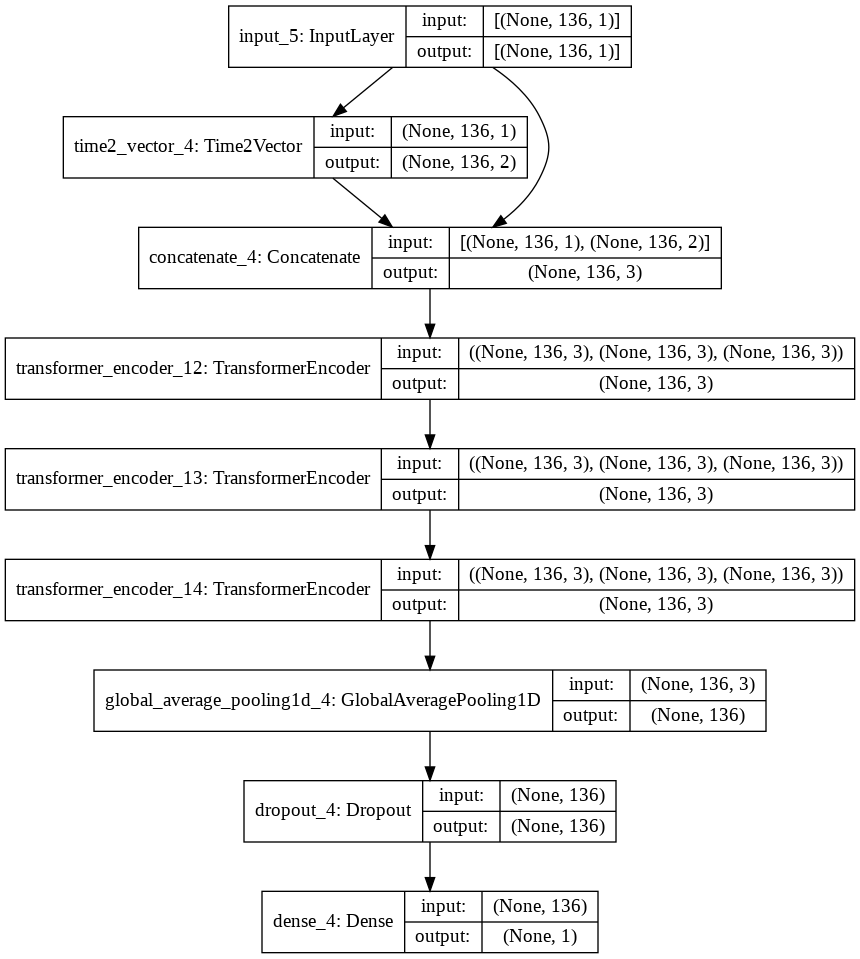

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)